In [1]:
import os
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import RocCurveDisplay, auc, mean_squared_error, roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform

from label_flip_revised.utils import create_dir


In [2]:
PATH_ROOT = Path(os.getcwd()).absolute().parent
print(PATH_ROOT)

/home/lukec/workspace/diva_01


In [3]:
path_output = os.path.join(PATH_ROOT, 'results_plot')
print(path_output)
create_dir(path_output)

/home/lukec/workspace/diva_01/results_plot


In [4]:
df_falfa = pd.read_csv(os.path.join(PATH_ROOT, 'results', 'real', 'real_falfa_nn_db.csv'))
print(df_falfa.shape)
df_falfa.head()

(90, 38)


,Data,F1,F1 SD,F1v,F2,F3,F4,N1,N2,N2 SD,...,Hubs SD,Path.Train,Path.Poison,Path.Test,Rate,Train.Clean,Test.Clean,Train.Poison,Test.Poison,Data.Base
0,breastcancer_std_falfa_nn_0.00.csv,0.712464,0.215349,0.066235,6.264744e-11,0.485714,0.000000,0.074725,0.366983,0.074135,...,0.225796,/home/lukec/workspace/label_flip_revised_new/d...,/home/lukec/workspace/label_flip_revised_new/d...,/home/lukec/workspace/label_flip_revised_new/d...,0.00,0.986813,0.982456,0.986813,0.982456,breastcancer_std
1,breastcancer_std_falfa_nn_0.05.csv,0.859098,0.101038,0.133480,1.440449e-06,0.696703,0.000000,0.103297,0.382469,0.070786,...,0.283660,/home/lukec/workspace/label_flip_revised_new/d...,/home/lukec/workspace/label_flip_revised_new/d...,/home/lukec/workspace/label_flip_revised_new/d...,0.05,0.986813,0.982456,0.982418,0.956140,breastcancer_std
2,breastcancer_std_falfa_nn_0.10.csv,0.844907,0.108064,0.240749,2.910036e-09,0.753846,0.316484,0.191209,0.409176,0.076152,...,0.225717,/home/lukec/workspace/label_flip_revised_new/d...,/home/lukec/workspace/label_flip_revised_new/d...,/home/lukec/workspace/label_flip_revised_new/d...,0.10,0.986813,0.982456,0.964835,0.868421,breastcancer_std
3,breastcancer_std_falfa_nn_0.15.csv,0.948572,0.034941,0.258380,2.631059e-06,0.712088,0.048352,0.153846,0.396442,0.077667,...,0.181392,/home/lukec/workspace/label_flip_revised_new/d...,/home/lukec/workspace/label_flip_revised_new/d...,/home/lukec/workspace/label_flip_revised_new/d...,0.15,0.986813,0.982456,0.984615,0.824561,breastcancer_std
4,breastcancer_std_falfa_nn_0.20.csv,0.919837,0.052507,0.311281,6.912120e-10,0.723077,0.270330,0.217582,0.415749,0.075189,...,0.225626,/home/lukec/workspace/label_flip_revised_new/d...,/home/lukec/workspace/label_flip_revised_new/d...,/home/lukec/workspace/label_flip_revised_new/d...,0.20,0.986813,0.982456,0.971429,0.728070,breastcancer_std


In [5]:
datanames = df_falfa['Data.Base'].unique()
datanames

array(['breastcancer_std', 'texture_subset_std', 'ringnorm_subset_std',
       'australian_std', 'cmc_std', 'yeast_subset_std',
       'abalone_subset_std', 'phoneme_subset_std', 'banknote_std',
       'htru2_subset_std'], dtype=object)

In [6]:
df_falfa.columns

Index(['Data', 'F1', 'F1 SD', 'F1v', 'F2', 'F3', 'F4', 'N1', 'N2', 'N2 SD',
       'N3', 'N3 SD', 'N4', 'N4 SD', 'T1', 'T1 SD', 'LSC', 'L1', 'L2', 'L3',
       'T2', 'T3', 'T4', 'C1', 'C2', 'Density', 'ClsCoef', 'Hubs', 'Hubs SD',
       'Path.Train', 'Path.Poison', 'Path.Test', 'Rate', 'Train.Clean',
       'Test.Clean', 'Train.Poison', 'Test.Poison', 'Data.Base'],
      dtype='object')

In [7]:
cols_cm = [
    'F1', 'F1 SD', 'F1v', 'F2', 'F3', 'F4', 'N1', 'N2', 'N2 SD',
    'N3', 'N3 SD', 'N4', 'N4 SD', 'T1', 'T1 SD', 'LSC', 'L1', 'L2', 'L3',
    'T2', 'T3', 'T4', 'C1', 'C2', 'Density', 'ClsCoef', 'Hubs', 'Hubs SD',
]
col_y = 'Test.Poison'

print(len(cols_cm))

28


In [8]:
attacks = ['falfa_nn', 'alfa_svm', 'rand_svm', 'poison_svm']
dfs = []
for att in attacks:
    df_ = pd.read_csv(os.path.join(PATH_ROOT, 'results', 'real', f'real_{att}_db.csv'))
    df_['Attack'] = att
    dfs.append(df_)

# NOTE: 
df = pd.concat(dfs, ignore_index=True)
print(df.shape)

(340, 39)


In [9]:
df

,Data,F1,F1 SD,F1v,F2,F3,F4,N1,N2,N2 SD,...,Path.Train,Path.Poison,Path.Test,Rate,Train.Clean,Test.Clean,Train.Poison,Test.Poison,Data.Base,Attack
0,breastcancer_std_falfa_nn_0.00.csv,0.712464,0.215349,0.066235,6.264744e-11,0.485714,0.000000,0.074725,0.366983,0.074135,...,/home/lukec/workspace/label_flip_revised_new/d...,/home/lukec/workspace/label_flip_revised_new/d...,/home/lukec/workspace/label_flip_revised_new/d...,0.00,0.986813,0.982456,0.986813,0.982456,breastcancer_std,falfa_nn
1,breastcancer_std_falfa_nn_0.05.csv,0.859098,0.101038,0.133480,1.440449e-06,0.696703,0.000000,0.103297,0.382469,0.070786,...,/home/lukec/workspace/label_flip_revised_new/d...,/home/lukec/workspace/label_flip_revised_new/d...,/home/lukec/workspace/label_flip_revised_new/d...,0.05,0.986813,0.982456,0.982418,0.956140,breastcancer_std,falfa_nn
2,breastcancer_std_falfa_nn_0.10.csv,0.844907,0.108064,0.240749,2.910036e-09,0.753846,0.316484,0.191209,0.409176,0.076152,...,/home/lukec/workspace/label_flip_revised_new/d...,/home/lukec/workspace/label_flip_revised_new/d...,/home/lukec/workspace/label_flip_revised_new/d...,0.10,0.986813,0.982456,0.964835,0.868421,breastcancer_std,falfa_nn
3,breastcancer_std_falfa_nn_0.15.csv,0.948572,0.034941,0.258380,2.631059e-06,0.712088,0.048352,0.153846,0.396442,0.077667,...,/home/lukec/workspace/label_flip_revised_new/d...,/home/lukec/workspace/label_flip_revised_new/d...,/home/lukec/workspace/label_flip_revised_new/d...,0.15,0.986813,0.982456,0.984615,0.824561,breastcancer_std,falfa_nn
4,breastcancer_std_falfa_nn_0.20.csv,0.919837,0.052507,0.311281,6.912120e-10,0.723077,0.270330,0.217582,0.415749,0.075189,...,/home/lukec/workspace/label_flip_revised_new/d...,/home/lukec/workspace/label_flip_revised_new/d...,/home/lukec/workspace/label_flip_revised_new/d...,0.20,0.986813,0.982456,0.971429,0.728070,breastcancer_std,falfa_nn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,yeast_subset_std_poison_svm_0.10.csv,0.990786,0.020445,0.768290,2.744995e-04,0.988294,0.936455,0.625418,0.478590,0.139140,...,/home/lukec/workspace/label_flip_revised_new/d...,/home/lukec/workspace/label_flip_revised_new/d...,/home/lukec/workspace/label_flip_revised_new/d...,0.10,0.726508,0.648045,0.730769,0.687151,yeast_subset_std,poison_svm
336,yeast_subset_std_poison_svm_0.15.csv,0.991886,0.017572,0.800329,2.960327e-04,0.988800,0.956800,0.627200,0.491407,0.154971,...,/home/lukec/workspace/label_flip_revised_new/d...,/home/lukec/workspace/label_flip_revised_new/d...,/home/lukec/workspace/label_flip_revised_new/d...,0.15,0.726508,0.648045,0.729600,0.670391,yeast_subset_std,poison_svm
337,yeast_subset_std_poison_svm_0.20.csv,0.996799,0.005893,0.913371,5.020123e-04,0.992331,0.969325,0.630368,0.495467,0.153496,...,/home/lukec/workspace/label_flip_revised_new/d...,/home/lukec/workspace/label_flip_revised_new/d...,/home/lukec/workspace/label_flip_revised_new/d...,0.20,0.726508,0.648045,0.728528,0.670391,yeast_subset_std,poison_svm
338,yeast_subset_std_poison_svm_0.25.csv,0.994281,0.010280,0.822829,5.493845e-04,0.994118,0.975000,0.638235,0.501441,0.162395,...,/home/lukec/workspace/label_flip_revised_new/d...,/home/lukec/workspace/label_flip_revised_new/d...,/home/lukec/workspace/label_flip_revised_new/d...,0.25,0.726508,0.648045,0.722059,0.675978,yeast_subset_std,poison_svm


In [10]:
N_ITER_SEARCH = 100

regressor = linear_model.Ridge()
param = {'alpha': loguniform(1e-4, 10),}
param_search = RandomizedSearchCV(regressor, param_distributions=param, n_iter=N_ITER_SEARCH, n_jobs=-1)
param_search.fit(df[cols_cm], df[col_y])

best_param = param_search.best_estimator_.get_params()
print('Best params:')
print(best_param)

Best params:
{'alpha': 0.0029221964789636814, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': 'deprecated', 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}


In [11]:
alpha = np.round(best_param['alpha'], 4)
print(alpha)

0.0029


In [12]:
df['Prediction'] = 0.
idx_col_pred = df.columns.get_indexer(['Prediction'])

counter = 0
for dname in datanames:
    # Anything other than test set
    # Only train with 1 attack and 1 noise
    df_train_1 = df[(df['Data.Base'] != dname) & (df['Attack'] == 'falfa_nn')]
    df_train_2 = df[(df['Data.Base'] != dname) & (df['Attack'] == 'rand_svm')]
    df_train = pd.concat([df_train_1, df_train_2], ignore_index=True)
    X_train = df_train[cols_cm]
    y_train = df_train[col_y]

    regressor = linear_model.Ridge(alpha=alpha)
    regressor.fit(X_train, y_train)

    for att in attacks:
        df_test = df[(df['Data.Base'] == dname) & (df['Attack'] == att)]
        X_test = df_test[cols_cm]
        counter += len(X_test)
        
        pred = regressor.predict(X_test)
        # Apply clipping
        pred = np.amin([pred, np.ones_like(pred)], axis=0)

        idx = df[(df['Data.Base'] == dname) & (df['Attack'] == att)].index
        df.iloc[idx, idx_col_pred] = pred

In [13]:
# Compute RMSE
for att in attacks:
    y_true = df[df['Attack'] == att]['Test.Poison']
    pred = df[df['Attack'] == att]['Prediction']
    rmse = np.sqrt(mean_squared_error(y_true, pred))
    print(f'[{att}] {rmse:.3f}')

[falfa_nn] 0.167
[alfa_svm] 0.196
[rand_svm] 0.119
[poison_svm] 0.151


In [14]:
FONTSIZE = 14
FIGSIZE = (4, 4)
NAMES = {
    'falfa_nn': 'FALFA',
    'alfa_svm': 'ALFA',
    'poison_svm': 'PoisSVM',
}
COLORS = {
    'falfa_nn': '#d32f2f',
    'alfa_svm': '#1976d2',
    'poison_svm': '#388e3c',
}
THRESHOLD = 0.05

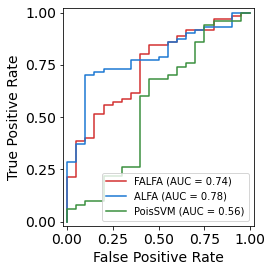

In [15]:
plt.rcParams["font.size"] = FONTSIZE
fig, ax = plt.subplots(figsize=FIGSIZE)
for att in ['falfa_nn', 'alfa_svm', 'poison_svm']:
    y_true = (df[df['Attack'] == att]['Rate'].to_numpy() > THRESHOLD).astype(int)
    y_score = np.abs((df[df['Attack'] == att]['Train.Poison'] - df[df['Attack'] == att]['Prediction']))
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot(ax=ax, name=NAMES[att], c=COLORS[att])
plt.legend(fontsize=FONTSIZE-4, loc='lower right')
plt.xticks(np.linspace(0, 1, num=5))
plt.yticks(np.linspace(0, 1, num=5))
plt.xlim(-0.02, 1.02)
plt.ylim(-0.02, 1.02)
plt.tight_layout()
plt.show()